<H2 style="text-align: center;">Deep Learning Assignment</H2>
<H5 style="text-align: center;">Thorsten Brückner, 18/02/23</H5>

<br><H2 style="text-align: center;">Image classification with the
CIFAR10 data set</H2>

<p style="text-align: center;">CIFAR-10 is a widely-used image classification dataset consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class.<br>It was created by the Canadian Institute for Advanced Research (CIFAR) and first released in 2009.<br>The dataset is commonly used for evaluating machine learning algorithms in object recognition tasks.</p><br>

<H3 style="text-align: center;">Objectives</H3>

<p style="text-align: center;">The objective of the project is to test and compare at least 5 different combinations of elements such as network architecture, data augmentation techniques, etc. for image classification.<br>The goal is to achieve a minimum of 80% accuracy on the test set and analyze the results to give a global comparison of the different combinations.</p>

<br><br><H5 style="text-align: center;">Imports and Global Settings</H5>

In [2]:
## IMPORTS ##   (double click to see the code)

# Build-in libraries
from platform import python_version
import os, random, warnings, time, datetime, math

# Tensorflow
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as regularizers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# Utilities
import visualkeras
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# Global Settings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
pd.options.mode.chained_assignment = None
phycial_devices = tf.config.list_physical_devices("GPU")

print("Python:", python_version())
print("Tensorflow:", tf.__version__)
print("Tensorflow-Datasets:", tfds.__version__)
print("Tensorflow-Addons:", tfa.__version__)
print("Pandas:", pd.__version__)
print("Numpy", np.__version__)
print("Matplotlib:", matplotlib.__version__)

Python: 3.9.13
Tensorflow: 2.7.1
Tensorflow-Datasets: 4.8.2
Tensorflow-Addons: 0.13.0
Pandas: 1.5.2
Numpy 1.23.5
Matplotlib: 3.6.2


<H5 style="text-align: center;">Custom Functions & Global Variables</H5>

In [4]:
## CUSTOM FUNCTIONS & VARIABLES ## (double click to see the code)

## --------------------------------------------------------------------------------
## VARIABLE DECLARATION
## --------------------------------------------------------------------------------
results_summary = pd.DataFrame(columns = ["Model", "Train Accuracy", "Test Accuracy", "Valid Accuracy", "Valid Loss", "Epochs", "Training Time"])
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


## --------------------------------------------------------------------------------
## NORMALIZATION FUNCTION
## --------------------------------------------------------------------------------
def normalize_img(image, label):
    """Normalizes the pixel values of an image tensor to the range [0, 1]."""
    return tf.cast(image, tf.float32) / 255.0, label


## --------------------------------------------------------------------------------
## AUGMENTATION FUNCTION
## --------------------------------------------------------------------------------
def augment(image, label, grey_chance = 0.1, shift_chance = 0.5, shift_fact = 0.1, rota_chance = 0.5, rota_angle = 15, flip = True):
    """
    Applies a set of image augmentations to an image.

    Args:
    image (tf.Tensor): Input image to augment.
    label (tf.Tensor): Input label for the image.
    grey_chance (float): Probability of converting image to grayscale (default: 0.1).
    shift_chance (float): Probability of randomly shifting the image (default: 0.5).
    shift_fact (float): Fraction of the image to shift by (default: 0.1).
    rota_chance (float): Probability of randomly rotating the image (default: 0.5).
    rota_angle (int): Maximum angle in degrees to rotate the image by (default: 15).
    flip (bool): Whether or not to randomly flip the image left-right (default: True).

    Returns:
    Tuple of the augmented image and its label.
    """
    
    if flip:
        image = tf.image.random_flip_left_right(image)

    if tf.random.uniform((), 0, 1) < grey_chance:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

    if tf.random.uniform((), 0, 1) < rota_chance:
        angle_radians = rota_angle * math.pi / 180
        image = tfa.image.rotate(image, angle_radians, fill_mode = "nearest")

    if tf.random.uniform((), 0, 1) < shift_chance:
        height, width, _ = image.shape
        shift_h, shift_w = int(height * shift_fact), int(width * shift_fact)
        if tf.random.uniform((), 0, 1) < 0.5:
            image = tf.image.random_crop(
                image, size = [height - shift_h, width - shift_w, 3])
            image = tf.image.resize(image, (height, width))
        else:
            if tf.random.uniform((), 0, 1) < 0.5:
                image = tfa.image.translate(image, [shift_h, shift_w], fill_mode = "nearest")

    return image, label


## --------------------------------------------------------------------------------
## PLOTTER FUNCTION FOR AUGMENTATION IMAGES
## --------------------------------------------------------------------------------
def plot_augmented_images(ds, augment_fn, examples, augment_args = None):
    """
    Plots a set of examples of original and augmented images.

    Args:
    - ds (tf.data.Dataset): Dataset of images to plot.
    - augment_fn (function): Augmentation function to apply to images (if specified).
    - examples (int): Number of examples to plot.
    - augment_args (dict): Dictionary of arguments to pass to augmentation function (default: None).

    Returns:
    Matplotlib figure object showing original and augmented images.
    """

    for images, labels in ds.take(1):
        augmented_images = []
        for image, label in zip(images, labels):
            if augment_args is not None:
                image, label = augment_fn(image, label, **augment_args)
            augmented_images.append(image)
        fig, axes = plt.subplots(nrows = examples, ncols = 4, figsize = (10, 10))
        for i in range(examples):
            axes[i, 0].imshow(images[i], interpolation = "nearest", aspect = "auto")
            if i == 0:
                axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(augmented_images[i], interpolation = "nearest", aspect = "auto")
            if i == 0:
                axes[i, 1].set_title("Augmented Image")
            axes[i, 1].axis("off")
            random_idx = random.randint(0, len(images) - 1)
            while random_idx == i:
                random_idx = random.randint(0, len(images) - 1)
            axes[i, 2].imshow(images[random_idx], interpolation = "nearest", aspect = "auto")
            if i == 0:
                axes[i, 2].set_title("Original Image")
            axes[i, 2].axis("off")
            axes[i, 3].imshow(augmented_images[random_idx], interpolation="nearest", aspect="auto")
            if i == 0:
                axes[i, 3].set_title("Augmented Image")
            axes[i, 3].axis("off")
            
    return fig


## --------------------------------------------------------------------------------
## DATA PREPARATION FUNCTION
## --------------------------------------------------------------------------------
def prep_data(AUTOTUNE=tf.data.experimental.AUTOTUNE, BATCHSIZE = 64, augment_fn = None, augment_args = None, fig_examples = 5, plot = True):
    """
    Prepares CIFAR-10 dataset for training by loading, normalizing, augmenting, and batching the data.

    Args:
    - AUTOTUNE (int): Number of parallel calls for mapping functions (default: tf.data.experimental.AUTOTUNE).
    - BATCHSIZE (int): Number of samples in each batch (default: 64).
    augment_fn (function): Augmentation function to apply to training dataset (default: None).
    - augment_args (dict): Dictionary of arguments to pass to augmentation function (default: None).
    - fig_examples (int): Number of examples to display in sample plot (default: 5).

    Returns:
    Tuple of three tf.data.Dataset objects (ds_train, ds_valid, ds_test) representing the training, validation, and test datasets. Each dataset is normalized, augmented (if specified), batched, and pre-fetched for efficiency.
    """

    (ds_test, ds_valid, ds_train), ds_info = tfds.load(
        "cifar10", split = ["test", "train[0:10000]", "train[10000:]"],
        as_supervised = True, shuffle_files = True, with_info = True)

    ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples - 10000)
    ds_train = ds_train.map(lambda image, label: augment_fn(image, label, **augment_args))
    ds_train = ds_train.batch(BATCHSIZE)
    ds_train = ds_train.prefetch(AUTOTUNE)

    ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
    ds_test = ds_test.batch(BATCHSIZE)
    ds_test = ds_test.prefetch(AUTOTUNE)

    ds_valid = ds_valid.map(normalize_img, num_parallel_calls=AUTOTUNE)
    ds_valid = ds_valid.batch(BATCHSIZE)
    ds_valid = ds_valid.prefetch(AUTOTUNE)
    
    if plot == True:
        fig = plot_augmented_images(ds_test, examples = fig_examples, augment_fn = augment_fn, augment_args = augment_args)

    return ds_train, ds_valid, ds_test, ds_info



## --------------------------------------------------------------------------------
## CALLBACKS FUNCTION
## --------------------------------------------------------------------------------
def callbacks(metric = "val_accuracy", early_patience = 25, lr_patience = 5, lr_adjust = True, lr_factor = 0.3, lr_schedule_rate = False):
    """
    Returns a list of Keras callbacks to use during training.

    Args:
    - metric (str): Name of the metric to monitor for checkpointing and reducing learning rate. Default is 'val_accuracy'.
    - early_patience (int): Number of epochs to wait before early stopping. Default is 25.
    - lr_patience (int): Number of epochs to wait before reducing learning rate. Default is 5.
    - lr_factor (float): Factor by which to reduce learning rate. Default is 0.3.
    - lr_schedule_rate (bool or float): If a float, the factor by which to reduce learning rate on schedule. If False, use ReduceLROnPlateau callback. Default is False.

    Returns:
    - A list of Keras callbacks to use during training.
    """

    callback_list = [
        keras.callbacks.ModelCheckpoint(
            os.path.join("checkpoints", "best_checkpoint"),
            save_weights_only = True,
            monitor = metric,
            save_best_only = True),
            
        tf.keras.callbacks.EarlyStopping(
            monitor = metric,
            patience = early_patience,
            verbose = 1)]

    if lr_adjust == True:
        if lr_schedule_rate == False:
            callback_list.append(tf.keras.callbacks.ReduceLROnPlateau(
                monitor = metric,
                factor = lr_factor,
                patience = lr_patience,
                verbose = 1))
        else:
            def lr_schedule(epoch, lr):
                if epoch < 5 or epoch % 5 != 0:
                    new_lr = lr
                else:
                    new_lr = lr * 0.95
                    print(f"Learning rate changed to {new_lr:.6f} at epoch {epoch}")
                return new_lr
            callback_list.append(tf.keras.callbacks.LearningRateScheduler(lr_schedule))

    return callback_list
    
## --------------------------------------------------------------------------------
## MODEL PIPELINE FUNCTION
## --------------------------------------------------------------------------------
def model_pipeline(ds_train, ds_valid, model_sequence, epochs, callbacks, optimizer = keras.optimizers.Adam(1e-3), loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)):

    """
    Trains a Keras model using the given training and validation datasets, model architecture, optimizer, loss function, and training parameters.

    Args:
    - ds_train (tf.data.Dataset): Training dataset.
    - ds_valid (tf.data.Dataset): Validation dataset.
    - model_sequence (list): List of Keras layers representing the model architecture.
    - epochs (int): Number of epochs to train the model.
    - callbacks (list): List of Keras callbacks to use during training.
    - optimizer (keras.optimizers.Optimizer): Keras optimizer to use during training. Defaults to Adam optimizer with a learning rate of 1e-3.
    - loss (keras.losses.Loss): Keras loss function to use during training. Defaults to SparseCategoricalCrossentropy.

    Returns:
    - model (keras.Model): Trained Keras model.
    - model_history (keras.callbacks.History): Keras history object containing training history.
    - elapsed_time (str): Time taken to train the model in the format HH:MM:SS.
    """

    timer = time.perf_counter()
    model = keras.Sequential(model_sequence)
    model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])
    model_history = model.fit(
        ds_train, 
        epochs = epochs, 
        validation_data = ds_valid, 
        use_multiprocessing = True, 
        callbacks = callbacks)
    elapsed_time = str(
        datetime.timedelta(seconds = (time.perf_counter() - timer))).rsplit('.', 1)[0]
    
    return model, model_history, elapsed_time

## --------------------------------------------------------------------------------
## BASIC EVALUATION AND MODEL STORAGE FUNCTION
## --------------------------------------------------------------------------------
def basic_evaluation(ds_train, ds_test, ds_valid, name, model, history, timing):
    model.load_weights(os.path.join("checkpoints", "best_checkpoint"))
    model.save(os.path.join("models", name + "_full.h5"))

    """
    Evaluate a trained model on training, testing, and validation sets, and plot the accuracy and loss curves.

    Args:
    - ds_train (tf.data.Dataset): Training set.
    - ds_test (tf.data.Dataset): Testing set.
    - ds_valid (tf.data.Dataset): Validation set.
    - name (str): Name of the model being evaluated.
    - model (tf.keras.Model): Trained model to be evaluated.
    - history (tf.keras.callbacks.History): Object containing training history.
    - timing (str): Time taken to train the model.
    """

    _, acc_train = model.evaluate(ds_train, verbose = 0)
    _, acc_test = model.evaluate(ds_test, verbose = 0)
    _, acc_val = model.evaluate(ds_valid, verbose = 0)
    val_loss = history.history["val_loss"][-1]

    acc_train, acc_test, acc_val = [round(metric * 100.0, 2) for metric in [acc_train, acc_test, acc_val]]
    val_loss = round(val_loss, 3)
    
    print(f"TRAIN ACCURACY → {acc_train} %")
    print(f"TEST ACCURACY → {acc_test} %")
    print(f"VALIDATION ACCURACY → {acc_val} %")
    print(f"VALIDATION LOSS → {val_loss}")
    print(f"TAKEN TIME → {timing} with {history.epoch[-1] + 1} epochs")
    
    new_row = {"Model": name, "Train Accuracy": acc_train, "Test Accuracy": acc_test, "Valid Accuracy": acc_val, "Valid Loss": val_loss, "Epochs": history.epoch[-1] + 1, "Training Time": timing}
    global results_summary
    if len(results_summary[results_summary["Model"] == name]) > 0:
        results_summary = pd.concat([results_summary, pd.DataFrame([new_row])])
        results_summary = results_summary.drop_duplicates(subset = ["Model"])
    else:
        results_summary = results_summary.append(new_row, ignore_index = True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
    ax1.set_title("Classification Accuracy")
    ax1.plot(history.history["accuracy"], color = "blue", label = "TRAINING")
    ax1.plot(history.history["val_accuracy"], color = "orange", label = "VALIDATION")
    ax1.legend()

    ax2.set_title("Cross Entropy Loss")
    ax2.plot(history.history["loss"], color = "blue", label = "TRAINING")
    ax2.plot(history.history["val_loss"], color = "orange", label = "VALIDATION")
    ax2.legend()

    plt.show()

print("Functions successfully loaded.")

Functions successfully loaded.


<br><H2 style="text-align: center;">Summary & Results</H2>
<p style="text-align: center;">(Spoiler Alert!)</p>

<ol>

  <li><b>Model 01:</b> Baseline <b> ~ 60 %</b></li>
  <li><b>Model 02:</b> Model 01 + Normalisation + Max Pooling<b> > 70%</b></li>
  <li><b>Model 03:</b> Model 02 + Dropout<b> > 75 %</b></li>
  <li><b>Model 04:</b> Model 03 + Image Augmentation <b> > 85 %</b></li>
  <li><b>Model 05:</b> Model 04 + Adaptive Learing Rate + Tuning <b> > 90 %</b></li>
  <li><b>Model XX:</b> Experimental Playground Model <b> > 90 %</b></b></li>

</ol>

,Model,Train Accuracy,Test Accuracy,Valid Accuracy,Valid Loss,Epochs,Training Time
0,model_01,78.49,59.56,59.32,4.180,15,0:06:26
1,model_02,94.17,72.52,72.16,1.538,20,0:02:56
2,model_03,90.55,77.47,78.12,0.691,40,0:06:06
3,model_04,86.25,84.41,85.30,0.462,40,0:08:36
4,model_05,97.25,89.69,90.03,0.339,104,0:48:17
5,model_xx,96.29,90.55,91.15,0.301,111,1:33:21


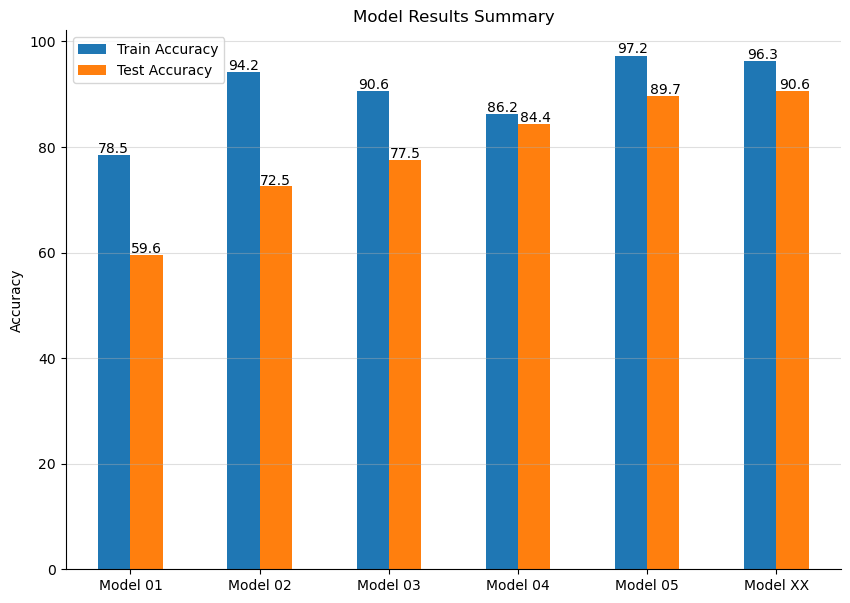

In [43]:
## RESULT SUMMARY TABLE & PLOT (double click to see the code)

display(results_summary)

fig, ax = plt.subplots(figsize=(10, 7))
results_summary[["Train Accuracy", "Test Accuracy"]].plot(kind = "bar", ax=ax, rot = 0)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.set_title("Model Results Summary")
ax.set_ylabel("Accuracy")
ax.set_xticklabels(["Model 01", "Model 02", "Model 03", "Model 04", "Model 05", "Model XX"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(axis = "y", linestyle= "-", alpha = 0.4)
plt.show()

<H4 style="text-align: center;"><b>Conclusions</b></H4>

- The selection of model architecture, optimizer, loss function, regularization techniques, and training hyperparameters can significantly influence a model's performance.

- When a model is too basic to capture the underlying patterns in the data, underfitting occurs, while overfitting occurs when a model is too complex and captures noise in the training data, resulting in poor generalization to new data.

- To avoid overfitting, regularization techniques like <b>dropout, batch normalization, kernel regularization, and data augmentation</b> can compel the model to improve generalization.

- <b>Saving the best weights</b> and loading them after training is a prudent approach to avoid overtraining of the model.

- <b>Early stopping</b> and <b>learning rate schedules</b> are effective strategies to prevent overfitting and enhance accuracy.

- Although increasing the number of epochs and using more complex models can improve model performance, it also raises the risk of overfitting, necessitating the use of regularization techniques.<br>
<br>

<p style="text-align: center;"><b>Final Words:</b><br><br>
Reaching an accuracy level of 80% in this project can be achieved with relative ease using simple methods. However, attaining an accuracy level of 90% is a challenging but realistic goal that can be accomplished with dedicated experimentation and optimization.</p>

<br><br><H2 style="text-align: center;">MODELLING</H2>
<H4 style="text-align: center;">General Methodology</H4>

<ol>

   <li><strong>Data Exploration:</strong> Since CIFAR-10 has been extensively explored and is well-suited to the project at hand, the typical step of data exploration will be omitted from the workflow.</li><br>

  <li><strong>Data Preparation:</strong> The CIFAR-10 dataset will be preprocessed and loaded to facilitate its use for model training, validation, and testing. This involves splitting and normalizing the data and formatting it to align with the Keras model. To achieve this, the tensorflow_datasets package and its dataset objects will be utilized to perform the dataset splits.</li><br>

  <li><strong>Data Augmentation:</strong> To prevent overfitting and increase the training dataset size, data augmentation techniques will be used to transform the existing data. This will create diverse samples for the model to learn from and improve its ability to perform on new data. Randomization will also be applied to introduce variability and prevent over-reliance on specific patterns. This will create a more adaptable and robust model.</li><br>

  <li><strong>Model Architecture: </strong>This project involves the development of five distinct neural network architectures with varying levels of complexity and components. Through experimentation, we aim to explore the impact of different model configurations on overall performance.</li><br>

  <li><strong>Model Compilation:</strong> Before beginning the training process, it is important to compile the model by specifying an appropriate optimizer, loss function, and metrics. This step is essential for configuring the model for learning and evaluating its performance.</li><br>

  <li><strong>Model Training:</strong> The model will be trained on the training data using the fit() method in Keras. The number of epochs, batch size, and other relevant parameters will be specified during the training.</li><br>

  <li><strong>Selecting Best Performing Weights:</strong> During the training process, the best performing weights were saved at regular intervals. Prior to evaluation, these weights will be loaded to ensure that the evaluation is performed using the best weights.</li><br> 
  
  <li><strong>Model Evaluation:</strong> The performance of each model will be assessed by comparing the loss and accuracy metrics across the training, validation, and test datasets. The objective is to achieve a low loss and high accuracy, which indicates that the model is able to make accurate predictions and generalize well to new data. Finally, the results of all five models will be compared to draw conclusions regarding the effectiveness of different model configurations and combinations, including their respective elements and how they contribute to the model's performance.</li>
</ol>

<br><br><H2 style="text-align: center;">MODEL 01 ("Baseline Model")</H2>

The first model will be a basic architecture consisting of three convolutional layers and one dense layer. No further modifications will be made to this model.<br>
<br>
<b>Results and Evalutation:</b><br><br>
The initial results for this basic model are as expected, with an accuracy below 60%. However, considering the CIFAR-10 dataset contains ten different classes, achieving an accuracy of 50% already exceeds the baseline accuracy by a factor of five. Therefore, while the model's performance is not ideal, it is not a complete failure. Nonetheless, more advanced models will be required to achieve higher accuracy on this dataset.

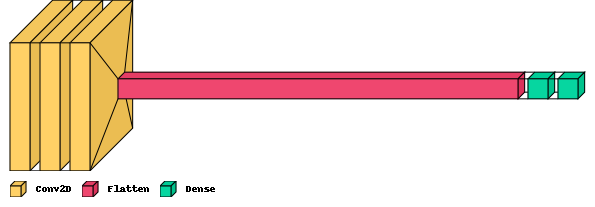

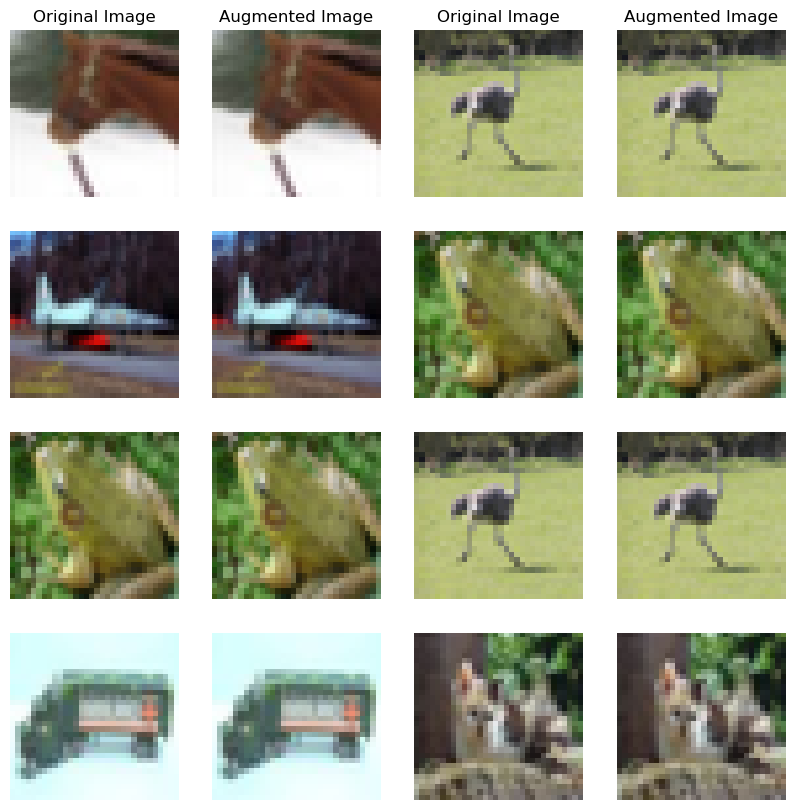

In [318]:
p, a, kr = "same", "relu", regularizers.l2(0.0001)
model_01 = keras.Sequential(
    [
        layers.InputLayer(input_shape = (32, 32, 3)),

        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.Conv2D(128, 3, padding = p, activation = a),

        layers.Flatten(),

        layers.Dense(32, activation = a),

        layers.Dense(10)
    ])

ds_train, ds_valid, ds_test, ds_info = prep_data(
    AUTOTUNE = tf.data.experimental.AUTOTUNE, BATCHSIZE = 64,
    fig_examples = 4,
    augment_fn = augment, augment_args = {
        "grey_chance": 0,
        "shift_chance": 0, "shift_fact": 0,
        "rota_chance": 0, "rota_angle": 0,
        "flip": False })
    
visualkeras.layered_view(model_01, legend = True)

In [319]:
callbacks_model = callbacks(
        metric = "val_accuracy", early_patience = 10, lr_patience = 5, lr_adjust = False)

mod, hist, timing = model_pipeline(
    ds_train = ds_train, ds_valid = ds_valid,
    model_sequence = model_01, epochs = 10, 
    callbacks = callbacks_model,
    optimizer = keras.optimizers.Adam(0.003), 
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True))

Epoch 1/10
625/625 [==============================] - 29s 43ms/step - loss: 1.7180 - accuracy: 0.3911 - val_loss: 1.4890 - val_accuracy: 0.4683
Epoch 2/10
625/625 [==============================] - 26s 42ms/step - loss: 1.3154 - accuracy: 0.5229 - val_loss: 1.3476 - val_accuracy: 0.5127
Epoch 3/10
625/625 [==============================] - 26s 42ms/step - loss: 1.1776 - accuracy: 0.5763 - val_loss: 1.1877 - val_accuracy: 0.5852
Epoch 4/10
625/625 [==============================] - 24s 38ms/step - loss: 1.0616 - accuracy: 0.6171 - val_loss: 1.1791 - val_accuracy: 0.5859
Epoch 5/10
625/625 [==============================] - 23s 37ms/step - loss: 0.9655 - accuracy: 0.6548 - val_loss: 1.2001 - val_accuracy: 0.5909
Epoch 6/10
625/625 [==============================] - 23s 37ms/step - loss: 0.8713 - accuracy: 0.6892 - val_loss: 1.2274 - val_accuracy: 0.5798
Epoch 7/10
625/625 [==============================] - 23s 36ms/step - loss: 0.7710 - accuracy: 0.7264 - val_loss: 1.3176 - val_accuracy:

TRAIN ACCURACY → 70.93 %
TEST ACCURACY → 58.82 %
VALIDATION ACCURACY → 59.09 %
VALIDATION LOSS → 1.681
TAKEN TIME → 0:04:04 with 10 epochs


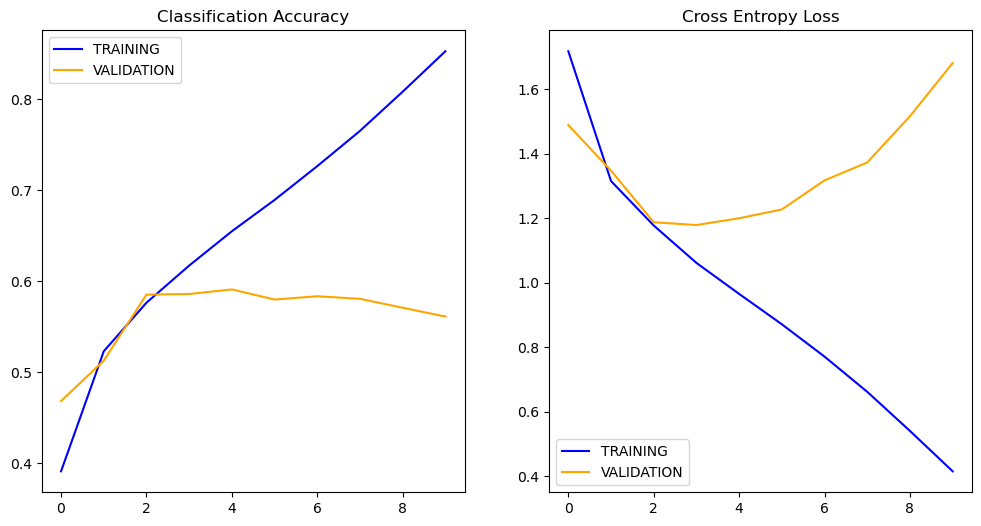

In [322]:
basic_evaluation(ds_train, ds_test, ds_valid, "model_01", mod, hist, timing)

<br><br><H2 style="text-align: center;">MODEL 02</H2>
<p style="text-align: center;"><b>Baseline + Batch Normalisation + Max pooling</b></p><br>

The next model has been enhanced with Batch normalisation and Max pooling<br>
<br>
<b>Results and Evalutation:</b><br><br>
The addition of batch normalization and max pooling to the model has improved its accuracy, reaching 70% and continuing to improve.<br>
Batch normalization standardizes input data, which reduces internal covariate shift and helps prevent the saturation of activation functions, and can act as a regularizer by adding noise to the input. 
<br>Max pooling reduces input size and simplifies the model, preventing it from becoming too complex and overfitting. By retaining the maximum value in a given region, it extracts the most relevant features from the input data.<br>
<br>
→ While these modifications have been effective, overfitting is still heavily present. Subsequent models will be modified to improve generalization ability.

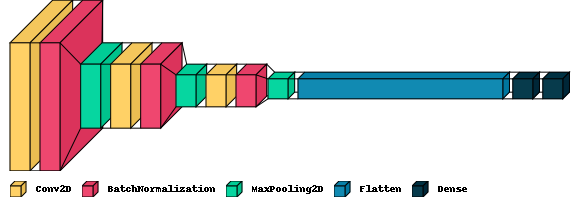

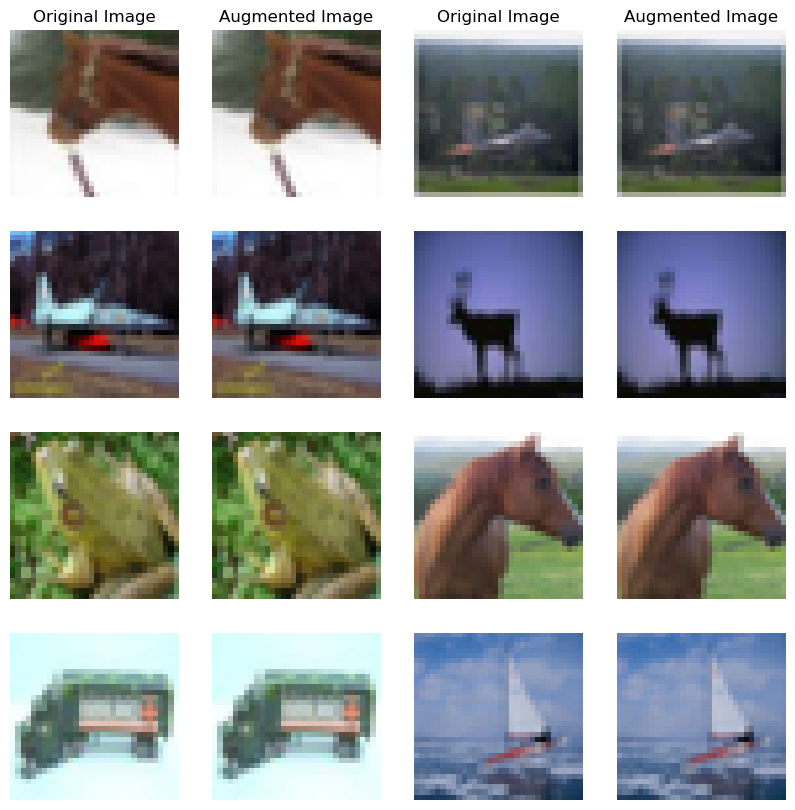

In [ ]:
p, a, kr = "same", "relu", regularizers.l2(0.0001)
model_02 = keras.Sequential(
    [
        layers.InputLayer(input_shape = (32, 32, 3)),

        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),

        layers.Dense(32, activation = a),

        layers.Dense(10)
    ])

ds_train, ds_valid, ds_test = prep_data(
    AUTOTUNE = tf.data.experimental.AUTOTUNE, BATCHSIZE = 64,
    fig_examples = 4,
    augment_fn = augment, augment_args = {
        "grey_chance": 0,
        "shift_chance": 0, "shift_fact": 0,
        "rota_chance": 0, "rota_angle": 0,
        "flip": False })
    
visualkeras.layered_view(model_02, legend = True)

In [298]:
callbacks_model = callbacks(
        metric = "val_accuracy", early_patience = 10, lr_patience = 5, lr_adjust = False)

mod, hist, timing = model_pipeline(
    ds_train = ds_train, ds_valid = ds_valid,
    model_sequence = model_02, epochs = 20, 
    callbacks = callbacks_model,
    optimizer = keras.optimizers.Adam(0.003), 
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True))

Epoch 1/20
625/625 [==============================] - 11s 14ms/step - loss: 1.5127 - accuracy: 0.4532 - val_loss: 1.9156 - val_accuracy: 0.3691
Epoch 2/20
625/625 [==============================] - 9s 14ms/step - loss: 1.0396 - accuracy: 0.6259 - val_loss: 1.0453 - val_accuracy: 0.6334
Epoch 3/20
625/625 [==============================] - 9s 14ms/step - loss: 0.8489 - accuracy: 0.6970 - val_loss: 0.9352 - val_accuracy: 0.6772
Epoch 4/20
625/625 [==============================] - 9s 14ms/step - loss: 0.7376 - accuracy: 0.7412 - val_loss: 1.0929 - val_accuracy: 0.6436
Epoch 5/20
625/625 [==============================] - 9s 15ms/step - loss: 0.6446 - accuracy: 0.7734 - val_loss: 0.9359 - val_accuracy: 0.6893
Epoch 6/20
625/625 [==============================] - 9s 14ms/step - loss: 0.5627 - accuracy: 0.8013 - val_loss: 0.9577 - val_accuracy: 0.6968
Epoch 7/20
625/625 [==============================] - 8s 13ms/step - loss: 0.4958 - accuracy: 0.8232 - val_loss: 1.3495 - val_accuracy: 0.631

TRAIN ACCURACY → 94.17 %
TEST ACCURACY → 72.52 %
VALIDATION ACCURACY → 72.16 %
VALIDATION LOSS → 1.538
TAKEN TIME → 0:02:56 with 20 epochs


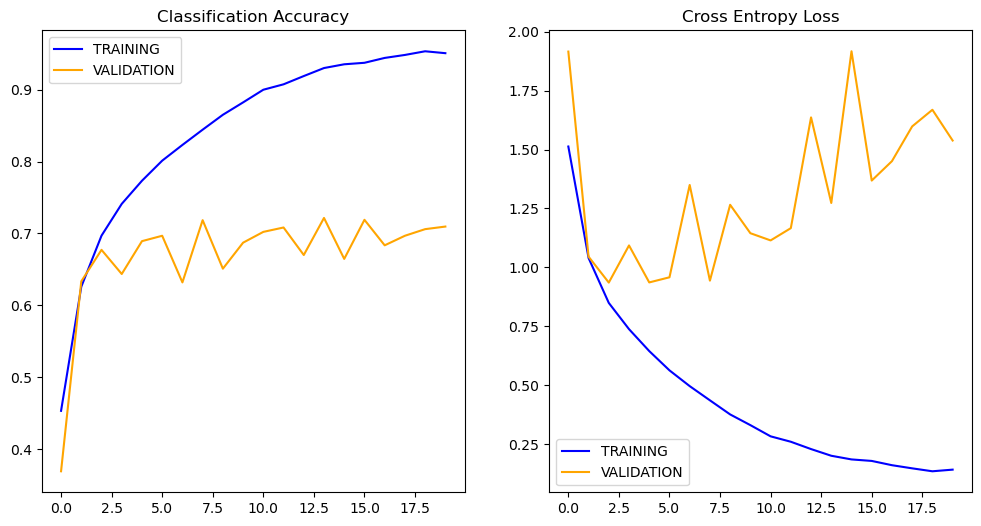

In [299]:
basic_evaluation(ds_train, ds_test, ds_valid, "model_02", mod, hist, timing)

<br><br><H2 style="text-align: center;">MODEL 03</H2>
<p style="text-align: center;"><b>Baseline + Batch Normalisation + Max pooling + Dropout</b></p><br>

In this model dropout layers have been added. This was done to tackle overfitting.<br>
<br>
<b>Results and Evalutation:</b><br><br>
We can see that the dropouts have dramatically reduced overfitting. The training against validation accuracy is now a lot closer to each other. Also the model overall performs better. We're already surpassing the 75% test accuracy. We're on a good way.

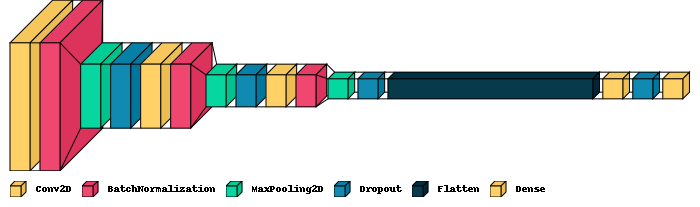

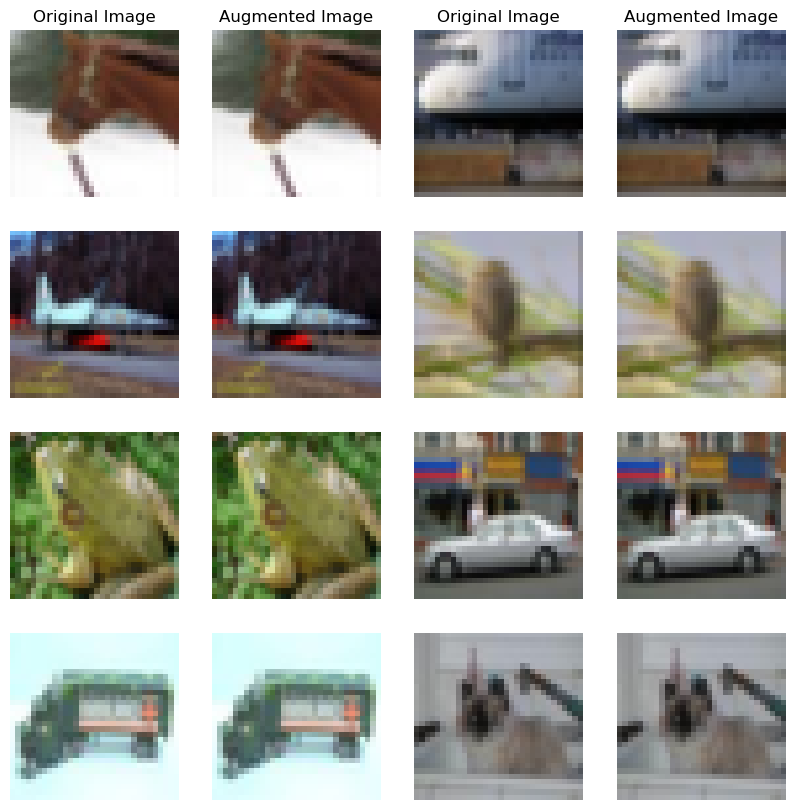

In [300]:
p, a, kr = "same", "relu", regularizers.l2(0.0001)
model_03 = keras.Sequential(
    [
        layers.InputLayer(input_shape = (32, 32, 3)),

        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Flatten(),

        layers.Dense(32, activation = a),
        layers.Dropout(0.2),

        layers.Dense(10)
    ])

ds_train, ds_valid, ds_test, ds_info = prep_data(
    AUTOTUNE = tf.data.experimental.AUTOTUNE, BATCHSIZE = 64,
    fig_examples = 4,
    augment_fn = augment, augment_args = {
        "grey_chance": 0,
        "shift_chance": 0, "shift_fact": 0,
        "rota_chance": 0, "rota_angle": 0,
        "flip": False })
    
visualkeras.layered_view(model_03, legend = True)

In [301]:
callbacks_model = callbacks(
        metric = "val_accuracy", early_patience = 10, lr_patience = 5, lr_adjust = False)

mod, hist, timing = model_pipeline(
    ds_train = ds_train, ds_valid = ds_valid,
    model_sequence = model_03, epochs = 40, 
    callbacks = callbacks_model,
    optimizer = keras.optimizers.Adam(0.003), 
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True))

Epoch 1/40
625/625 [==============================] - 12s 16ms/step - loss: 1.8068 - accuracy: 0.3213 - val_loss: 1.6102 - val_accuracy: 0.4380
Epoch 2/40
625/625 [==============================] - 9s 15ms/step - loss: 1.4684 - accuracy: 0.4570 - val_loss: 1.6815 - val_accuracy: 0.4315
Epoch 3/40
625/625 [==============================] - 10s 15ms/step - loss: 1.3463 - accuracy: 0.5051 - val_loss: 1.1150 - val_accuracy: 0.6125
Epoch 4/40
625/625 [==============================] - 9s 15ms/step - loss: 1.2551 - accuracy: 0.5468 - val_loss: 1.0698 - val_accuracy: 0.6275
Epoch 5/40
625/625 [==============================] - 9s 15ms/step - loss: 1.1607 - accuracy: 0.5883 - val_loss: 1.0923 - val_accuracy: 0.6261
Epoch 6/40
625/625 [==============================] - 9s 14ms/step - loss: 1.0881 - accuracy: 0.6188 - val_loss: 0.9858 - val_accuracy: 0.6689
Epoch 7/40
625/625 [==============================] - 9s 14ms/step - loss: 1.0317 - accuracy: 0.6391 - val_loss: 1.0042 - val_accuracy: 0.66

TRAIN ACCURACY → 90.55 %
TEST ACCURACY → 77.47 %
VALIDATION ACCURACY → 78.12 %
VALIDATION LOSS → 0.691
TAKEN TIME → 0:06:06 with 40 epochs


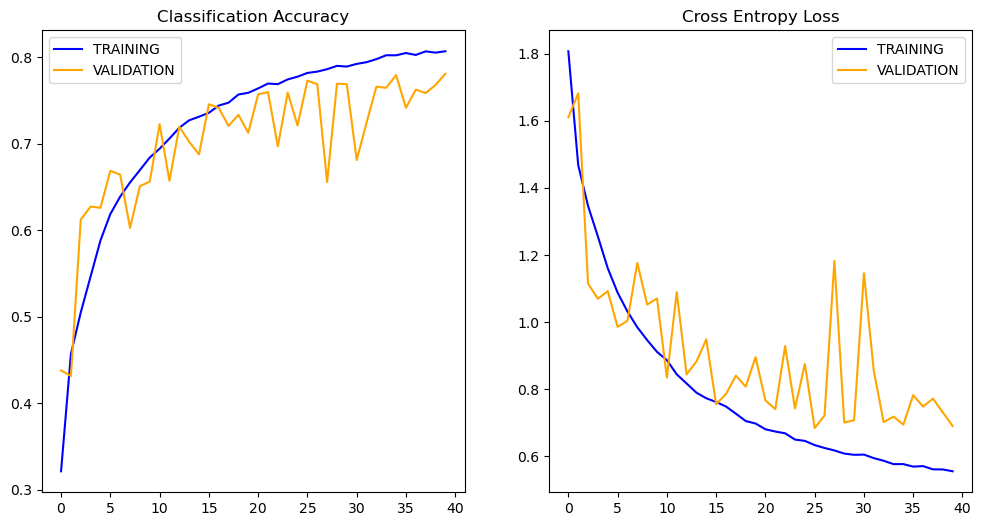

In [302]:
basic_evaluation(ds_train, ds_test, ds_valid, "model_03", mod, hist, timing)

<br><br><H2 style="text-align: center;">MODEL 04</H2>
<p style="text-align: center;"><b>Baseline + Batch Normalisation + Max pooling + Dropout + Image Augmentation</b></p><br>

This advanced model incorporates several key techniques to improve performance, including batch normalization, max pooling, dropout, and image augmentation.<br>
By applying image augmentation techniques such as random image flips, crops, grayscale, and rotations, the model is able to learn more robust features and generalize better to new, unseen images.

<br>
<b>Results and Evalutation:</b><br><br>
Model 04 has achieved a test accuracy of above 85%, outperforming all previous models. This improvement can be attributed to the various techniques used to prevent overfitting, such as dropout and batch normalization, which reduce the impact of noisy or irrelevant features during training. Max pooling, on the other hand, helps to reduce the dimensionality of the feature maps and increase computational efficiency, while image augmentation helps to expand the size of the training dataset and improve the model's ability to handle variations in lighting, orientation, and other factors that can affect image appearance.

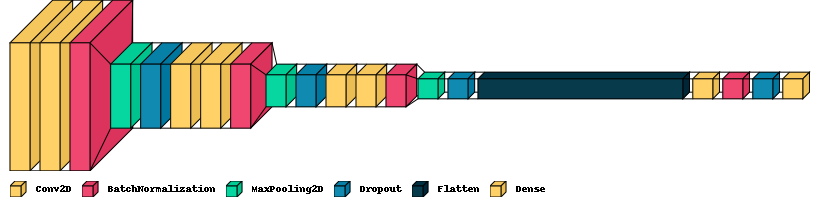

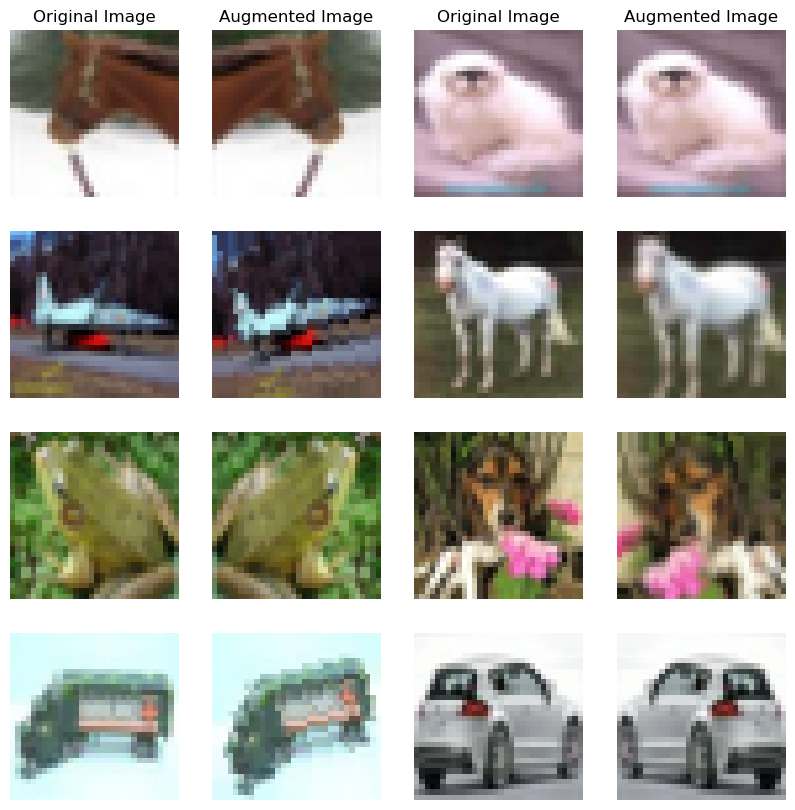

In [326]:
p, a, kr = "same", "relu", regularizers.l2(0.0001)
model_04 = keras.Sequential(
    [
        layers.InputLayer(input_shape = (32, 32, 3)),

        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Flatten(),

        layers.Dense(32, activation = a),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(10)
    ])

ds_train, ds_valid, ds_test, ds_info = prep_data(
    AUTOTUNE = tf.data.experimental.AUTOTUNE, BATCHSIZE = 64,
    fig_examples = 4,
    augment_fn = augment, augment_args = {
        "grey_chance": 0.1,
        "shift_chance": 0.5, "shift_fact": 0.1,
        "rota_chance": 0.5, "rota_angle": 15,
        "flip": True })
    
visualkeras.layered_view(model_04, legend = True)

In [327]:
callbacks_model = callbacks(
        metric = "val_accuracy", early_patience = 10, lr_patience = 5, lr_adjust = False)

mod, hist, timing = model_pipeline(
    ds_train = ds_train, ds_valid = ds_valid,
    model_sequence = model_04, epochs = 40, 
    callbacks = callbacks_model,
    optimizer = keras.optimizers.Adam(0.003), 
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True))

Epoch 1/40
625/625 [==============================] - 16s 23ms/step - loss: 1.5982 - accuracy: 0.4232 - val_loss: 1.5201 - val_accuracy: 0.4743
Epoch 2/40
625/625 [==============================] - 14s 23ms/step - loss: 1.2354 - accuracy: 0.5631 - val_loss: 1.1210 - val_accuracy: 0.6179
Epoch 3/40
625/625 [==============================] - 14s 22ms/step - loss: 1.0849 - accuracy: 0.6178 - val_loss: 0.9817 - val_accuracy: 0.6577
Epoch 4/40
625/625 [==============================] - 13s 21ms/step - loss: 0.9909 - accuracy: 0.6563 - val_loss: 0.8908 - val_accuracy: 0.6910
Epoch 5/40
625/625 [==============================] - 13s 20ms/step - loss: 0.9210 - accuracy: 0.6793 - val_loss: 0.8301 - val_accuracy: 0.7080
Epoch 6/40
625/625 [==============================] - 13s 20ms/step - loss: 0.8689 - accuracy: 0.7011 - val_loss: 0.8457 - val_accuracy: 0.7179
Epoch 7/40
625/625 [==============================] - 13s 20ms/step - loss: 0.8316 - accuracy: 0.7128 - val_loss: 0.8334 - val_accuracy:

TRAIN ACCURACY → 86.25 %
TEST ACCURACY → 84.41 %
VALIDATION ACCURACY → 85.3 %
VALIDATION LOSS → 0.462
TAKEN TIME → 0:08:36 with 40 epochs


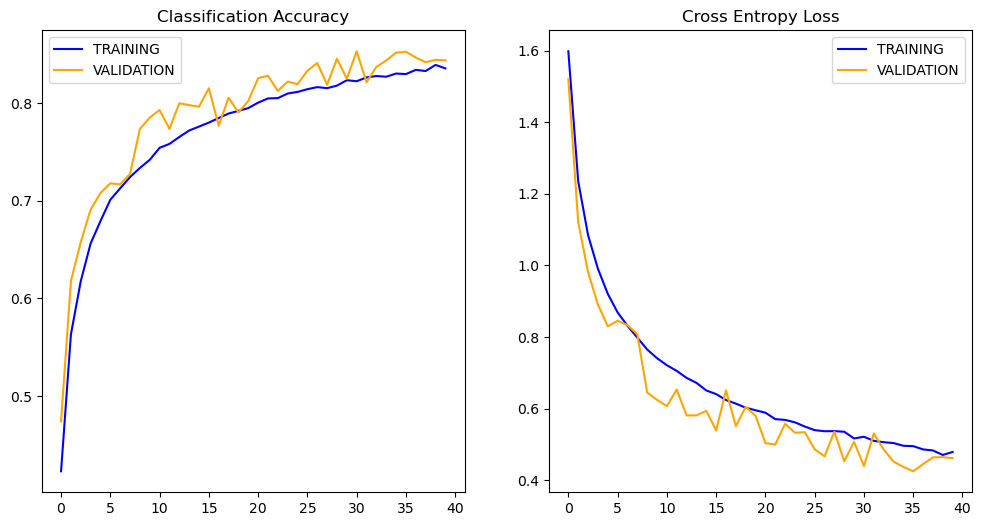

In [328]:
basic_evaluation(ds_train, ds_test, ds_valid, "model_04", mod, hist, timing)

<br><br><H2 style="text-align: center;">MODEL 05 ("Ultimate Model")</H2>


The "ultimate model" incorporates a comprehensive set of modifications aimed at improving its performance. It follows a complex sequential structure that includes a sequence of <b>convolution layers</b> that progressively increase in kernel size (32, 64, 128, 256), with each convolution layer pair followed by <b>batch normalization</b> and increasing <b>dropout</b> rates that range from 15% to 50%. A default <b>maxpooling</b> layer is applied after each convolution layer pair. The model also features <b>progressive dense layers</b> (2 x 64, 1x 128, 1x 256) and a <b>final dense layer</b> with an underlying softmax function for 10 classes.<br>
<b>Image augmentation</b> is employed to enhance the model's ability to learn and generalize from the data. This includes random grayscale application with a 15% probability, x-y translation with a 25% probability, and rotation with a 50% probability.<br>
The model features a <b>progressive and adaptive learning rate</b> that starts at 0.003 and decreases by a factor of 0.2 with patience 7 to achieve optimal performance.

<b>Modifications:</b>
<ul>
  <li>12 progressive convolution layers (3 x 32, 23 x 64, 3 x 128, 3 x 256)</li>
  <li>Batch normalization for improved training stability</li>
  <li>Maxpooling to downsample feature maps</li>
  <li>Progressive dropout (ranging from 0.15 to 0.5) to prevent overfitting</li>
  <li>Final dense layer with underlying softmax for 10 classes</li>
  <li>Image augmentation to improve the model's ability to generalize from the data. This includes:</li>
    <ul>
      <li>15% chance of grayscale conversion</li>
      <li>25% chance to shift the image by 10% (either shift and fill or shift and resize)</li>
      <li>50% chance to rotate the image by 15° angle</li>
    </ul>
  <li>Progressive and adaptive learning rate. The learning rate starts at 0.005 and decreases by a factor of 0.2 with patience 8 to achieve optimal performance.</li>
</ul>
<br>
<b>Results and Evalutation:</b><br><br>
The model's performance is outstanding, achieving an accuracy of approximately 90% and exhibiting a small loss value after numerous runs. The combination of all the model's elements is undoubtedly responsible for its exceptional performance. Although additional fine-tuning of the model parameters may result in even better performance, it has been determined that the current level of performance is highly satisfactory, and thus, we will not be pursuing further adjustments.

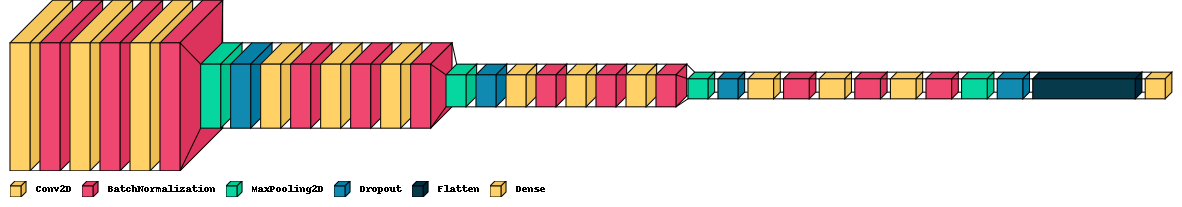

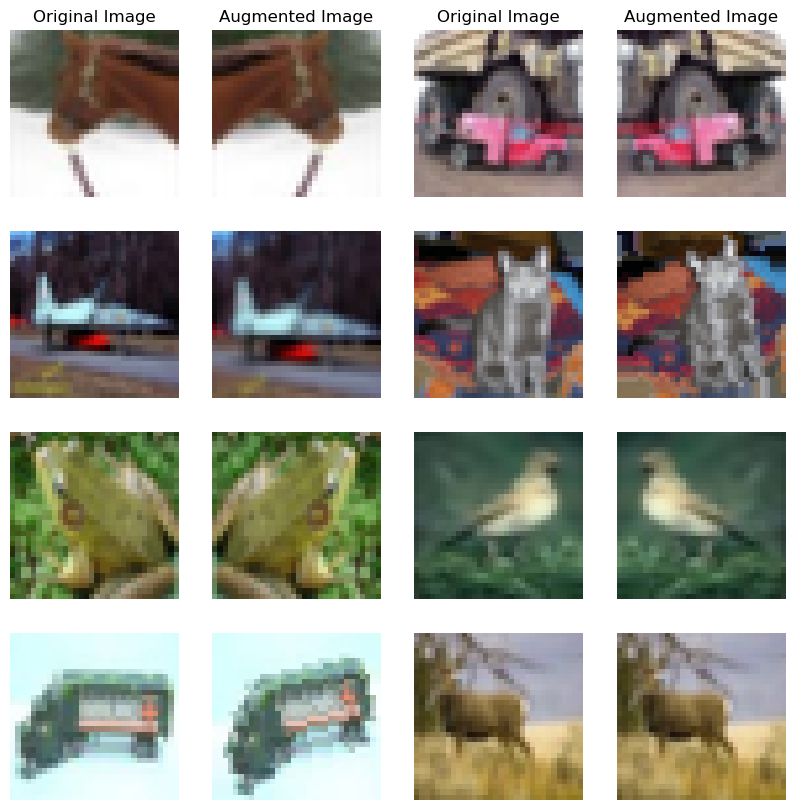

In [341]:
p, a, kr = "same", "relu", regularizers.l2(0.0001)
model_05 = keras.Sequential(
    [
        layers.InputLayer(input_shape = (32, 32, 3)),

        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.Conv2D(256, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(256, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(256, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Flatten(),
        
        layers.Dense(10)
    ])

ds_train, ds_valid, ds_test, ds_info = prep_data(
    AUTOTUNE = tf.data.experimental.AUTOTUNE, BATCHSIZE = 64,
    fig_examples = 4,
    augment_fn = augment, augment_args = {
        "grey_chance": 0.1,
        "shift_chance": 0.5, "shift_fact": 0.1,
        "rota_chance": 0.5, "rota_angle": 15,
        "flip": True })
    
visualkeras.layered_view(model_05, legend = True)

In [342]:
callbacks_model = callbacks(
        metric = "val_accuracy", early_patience = 20, lr_patience = 8, lr_factor = 0.2, lr_schedule_rate = False)

mod, hist, timing = model_pipeline(
    ds_train = ds_train, ds_valid = ds_valid,
    model_sequence = model_05, epochs = 200, 
    callbacks = callbacks_model,
    optimizer = keras.optimizers.Adam(0.0005), 
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True))

Epoch 1/200
625/625 [==============================] - 34s 52ms/step - loss: 2.3080 - accuracy: 0.3173 - val_loss: 1.7591 - val_accuracy: 0.4107
Epoch 2/200
625/625 [==============================] - 33s 53ms/step - loss: 1.7136 - accuracy: 0.4496 - val_loss: 2.0112 - val_accuracy: 0.4286
Epoch 3/200
625/625 [==============================] - 32s 52ms/step - loss: 1.4762 - accuracy: 0.5157 - val_loss: 1.2806 - val_accuracy: 0.5487
Epoch 4/200
625/625 [==============================] - 32s 51ms/step - loss: 1.2830 - accuracy: 0.5728 - val_loss: 1.0736 - val_accuracy: 0.6340
Epoch 5/200
625/625 [==============================] - 33s 52ms/step - loss: 1.1751 - accuracy: 0.6079 - val_loss: 1.0508 - val_accuracy: 0.6367
Epoch 6/200
625/625 [==============================] - 32s 51ms/step - loss: 1.0567 - accuracy: 0.6411 - val_loss: 0.8795 - val_accuracy: 0.6931
Epoch 7/200
625/625 [==============================] - 32s 51ms/step - loss: 1.0234 - accuracy: 0.6540 - val_loss: 0.9043 - val_ac

TRAIN ACCURACY → 97.25 %
TEST ACCURACY → 89.69 %
VALIDATION ACCURACY → 90.03 %
VALIDATION LOSS → 0.339
TAKEN TIME → 0:48:17 with 104 epochs


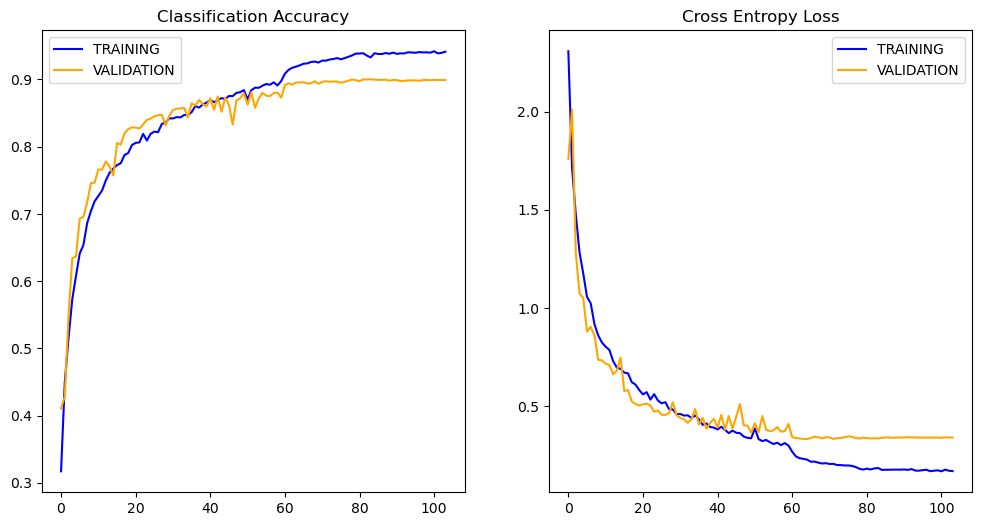

In [343]:
basic_evaluation(ds_train, ds_test, ds_valid, "model_05", mod, hist, timing)

<br><H3 style="text-align: center;">Predictions</H3>
<p style="text-align: center;">with Model_05 on random test images</p>

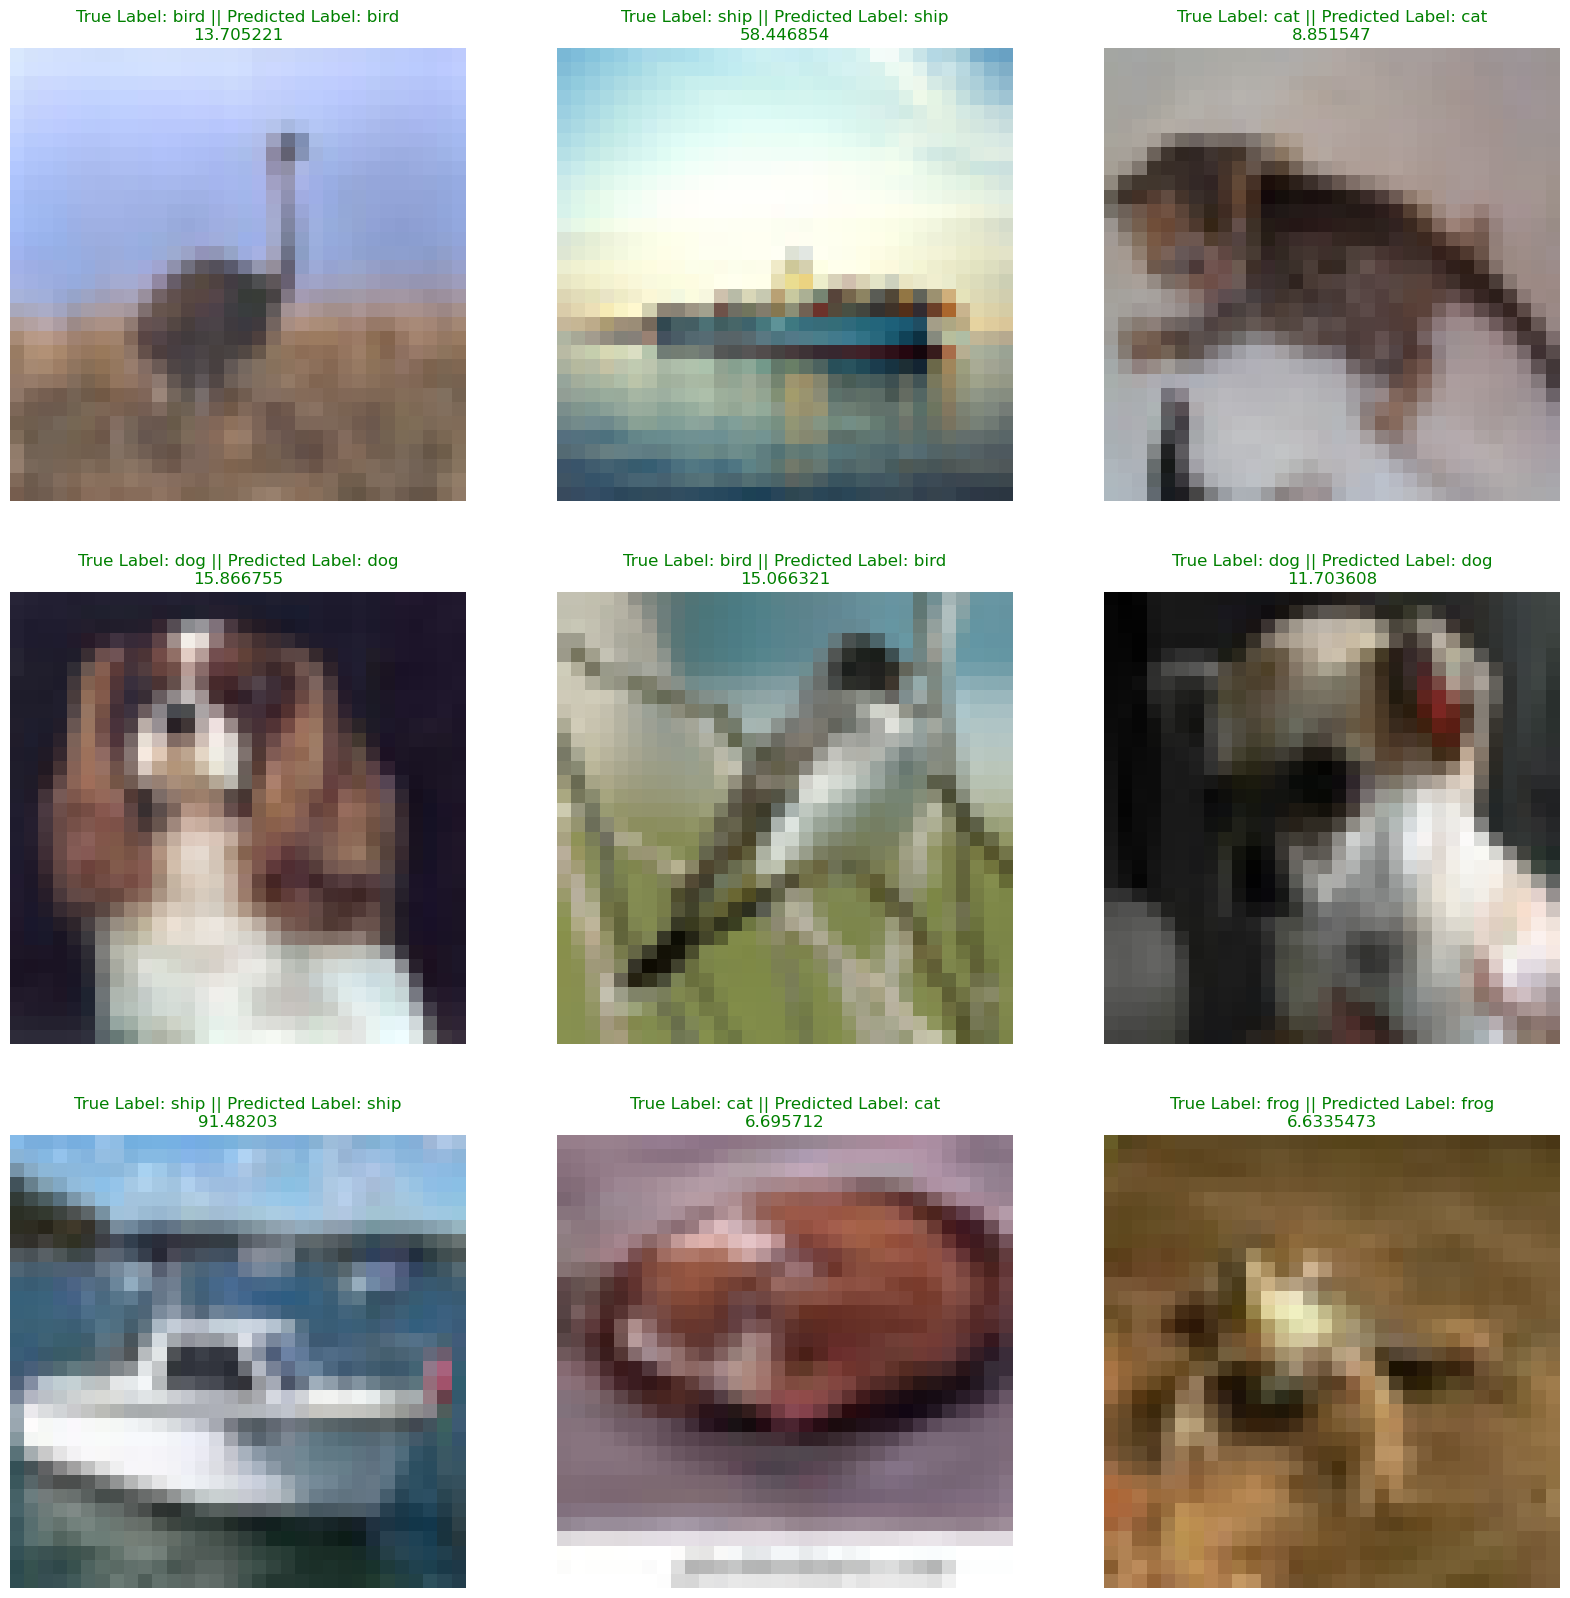

In [356]:
pred = model_05.predict(ds_test)
pred_classes = np.argmax(pred, axis = 1)
test_labels = np.concatenate([y for x, y in ds_test], axis = 0)

test_image_batches = []
for images, labels in ds_test.take(-1):
    test_image_batches.append(images.numpy())
test_images = [item for sublist in test_image_batches for item in sublist]

plt.figure(figsize = (20,20))
for i in range(9):
    
    random_int_index = random.choice(range(len(test_images)))
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[random_int_index], interpolation = "nearest", aspect = "auto")

    if test_labels[random_int_index] == pred_classes[random_int_index]:
        color = "green"
    else:
        color = "red"

    plt.title("True Label: " + class_names[test_labels[random_int_index]] + " || " + "Predicted Label: " + class_names[pred_classes[random_int_index]] + "\n" + str(np.asarray(tf.reduce_max(pred, axis = 1))[random_int_index]), c = color)
    plt.axis(False)

<br><br><br><br><br><br><H2 style="text-align: center;">MODEL XX (PLAYGROUND)</H2>
<H4 style="text-align: center;">Playing a little without any expectations<br>Keeping it included, as it might randomly beat the highscore :)</H4>

In [37]:
p, a, kr = "same", "relu", regularizers.l2(0.0001)
model_xx = keras.Sequential(
    [
        layers.InputLayer(input_shape = (32, 32, 3)),

        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.35),

        layers.Conv2D(256, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(256, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(256, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.Conv2D(512, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(512, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.Conv2D(512, 3, padding = p, activation = a),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.45),

        layers.Flatten(),

        layers.Dense(512, activation = a),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation = a),
        layers.BatchNormalization(),
        layers.Dropout(0.5),    
    
        layers.Dense(10)
    ])

ds_train, ds_valid, ds_test, ds_info = prep_data(
    AUTOTUNE = tf.data.experimental.AUTOTUNE, BATCHSIZE = 64,
    fig_examples = 4, plot = False,
    augment_fn = augment, augment_args = {
        "grey_chance": 0.15,
        "shift_chance": 0.75, "shift_fact": 0.125,
        "rota_chance": 0.5, "rota_angle": 15,
        "flip": True })

callbacks_model = callbacks(
        metric = "val_accuracy", early_patience = 16, lr_patience = 5, lr_factor = 0.2, lr_schedule_rate = False)

mod, hist, timing = model_pipeline(
    ds_train = ds_train, ds_valid = ds_valid,
    model_sequence = model_xx, epochs = 200, 
    callbacks = callbacks_model,
    optimizer = keras.optimizers.Adam(0.001), 
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True))

Epoch 1/200
625/625 [==============================] - 56s 85ms/step - loss: 2.2480 - accuracy: 0.2472 - val_loss: 1.8387 - val_accuracy: 0.3534
Epoch 2/200
625/625 [==============================] - 51s 81ms/step - loss: 1.7164 - accuracy: 0.3776 - val_loss: 1.8125 - val_accuracy: 0.3888
Epoch 3/200
625/625 [==============================] - 48s 77ms/step - loss: 1.4832 - accuracy: 0.4696 - val_loss: 1.5175 - val_accuracy: 0.5054
Epoch 4/200
625/625 [==============================] - 48s 77ms/step - loss: 1.3425 - accuracy: 0.5257 - val_loss: 1.1234 - val_accuracy: 0.6082
Epoch 5/200
625/625 [==============================] - 48s 77ms/step - loss: 1.2092 - accuracy: 0.5796 - val_loss: 1.0476 - val_accuracy: 0.6376
Epoch 6/200
625/625 [==============================] - 47s 74ms/step - loss: 1.1268 - accuracy: 0.6141 - val_loss: 1.0360 - val_accuracy: 0.6474
Epoch 7/200
625/625 [==============================] - 42s 68ms/step - loss: 1.0679 - accuracy: 0.6350 - val_loss: 1.2145 - val_ac

TRAIN ACCURACY → 96.29 %
TEST ACCURACY → 90.55 %
VALIDATION ACCURACY → 91.15 %
VALIDATION LOSS → 0.301
TAKEN TIME → 1:33:21 with 111 epochs


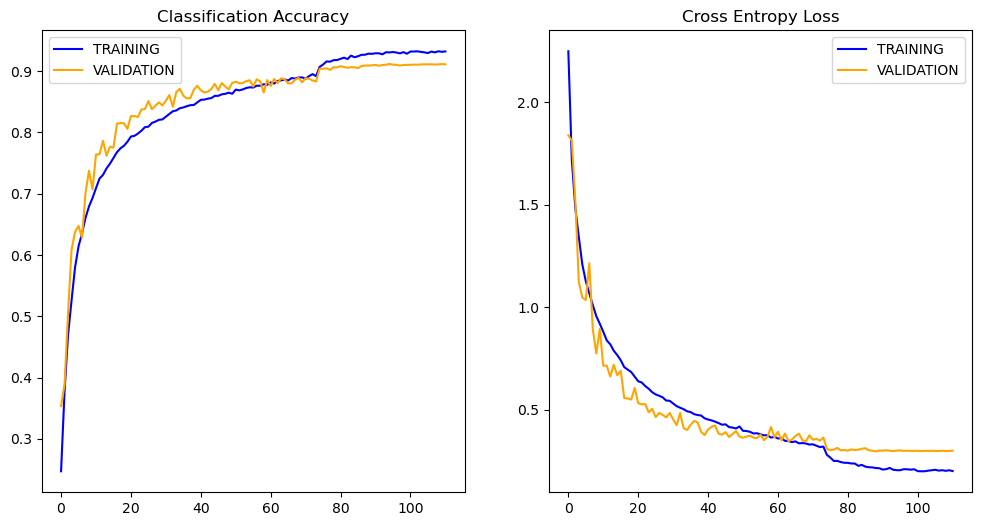

In [41]:
basic_evaluation(ds_train, ds_test, ds_valid, "model_xx", mod, hist, timing)